In [1]:
import os
os.environ["SPS_HOME"] = "/Users/fpetri/packages/fsps" 

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import lbg_forecast.sps as sps
import lbg_forecast.sfh as sfh
import lbg_forecast.priors as pr
import lbg_forecast.hyperparameters as hyp
import lbg_forecast.population_model as pop
import lbg_forecast.zhistory as zh
import lbg_forecast.priors as pr

In [3]:
#sps_model = sps.initialise_sps_model(neb_em=False)

In [4]:
hyperparameter_mu_bounds, hyperparameter_sigma_max = hyp.default_hyperparameter_bounds()

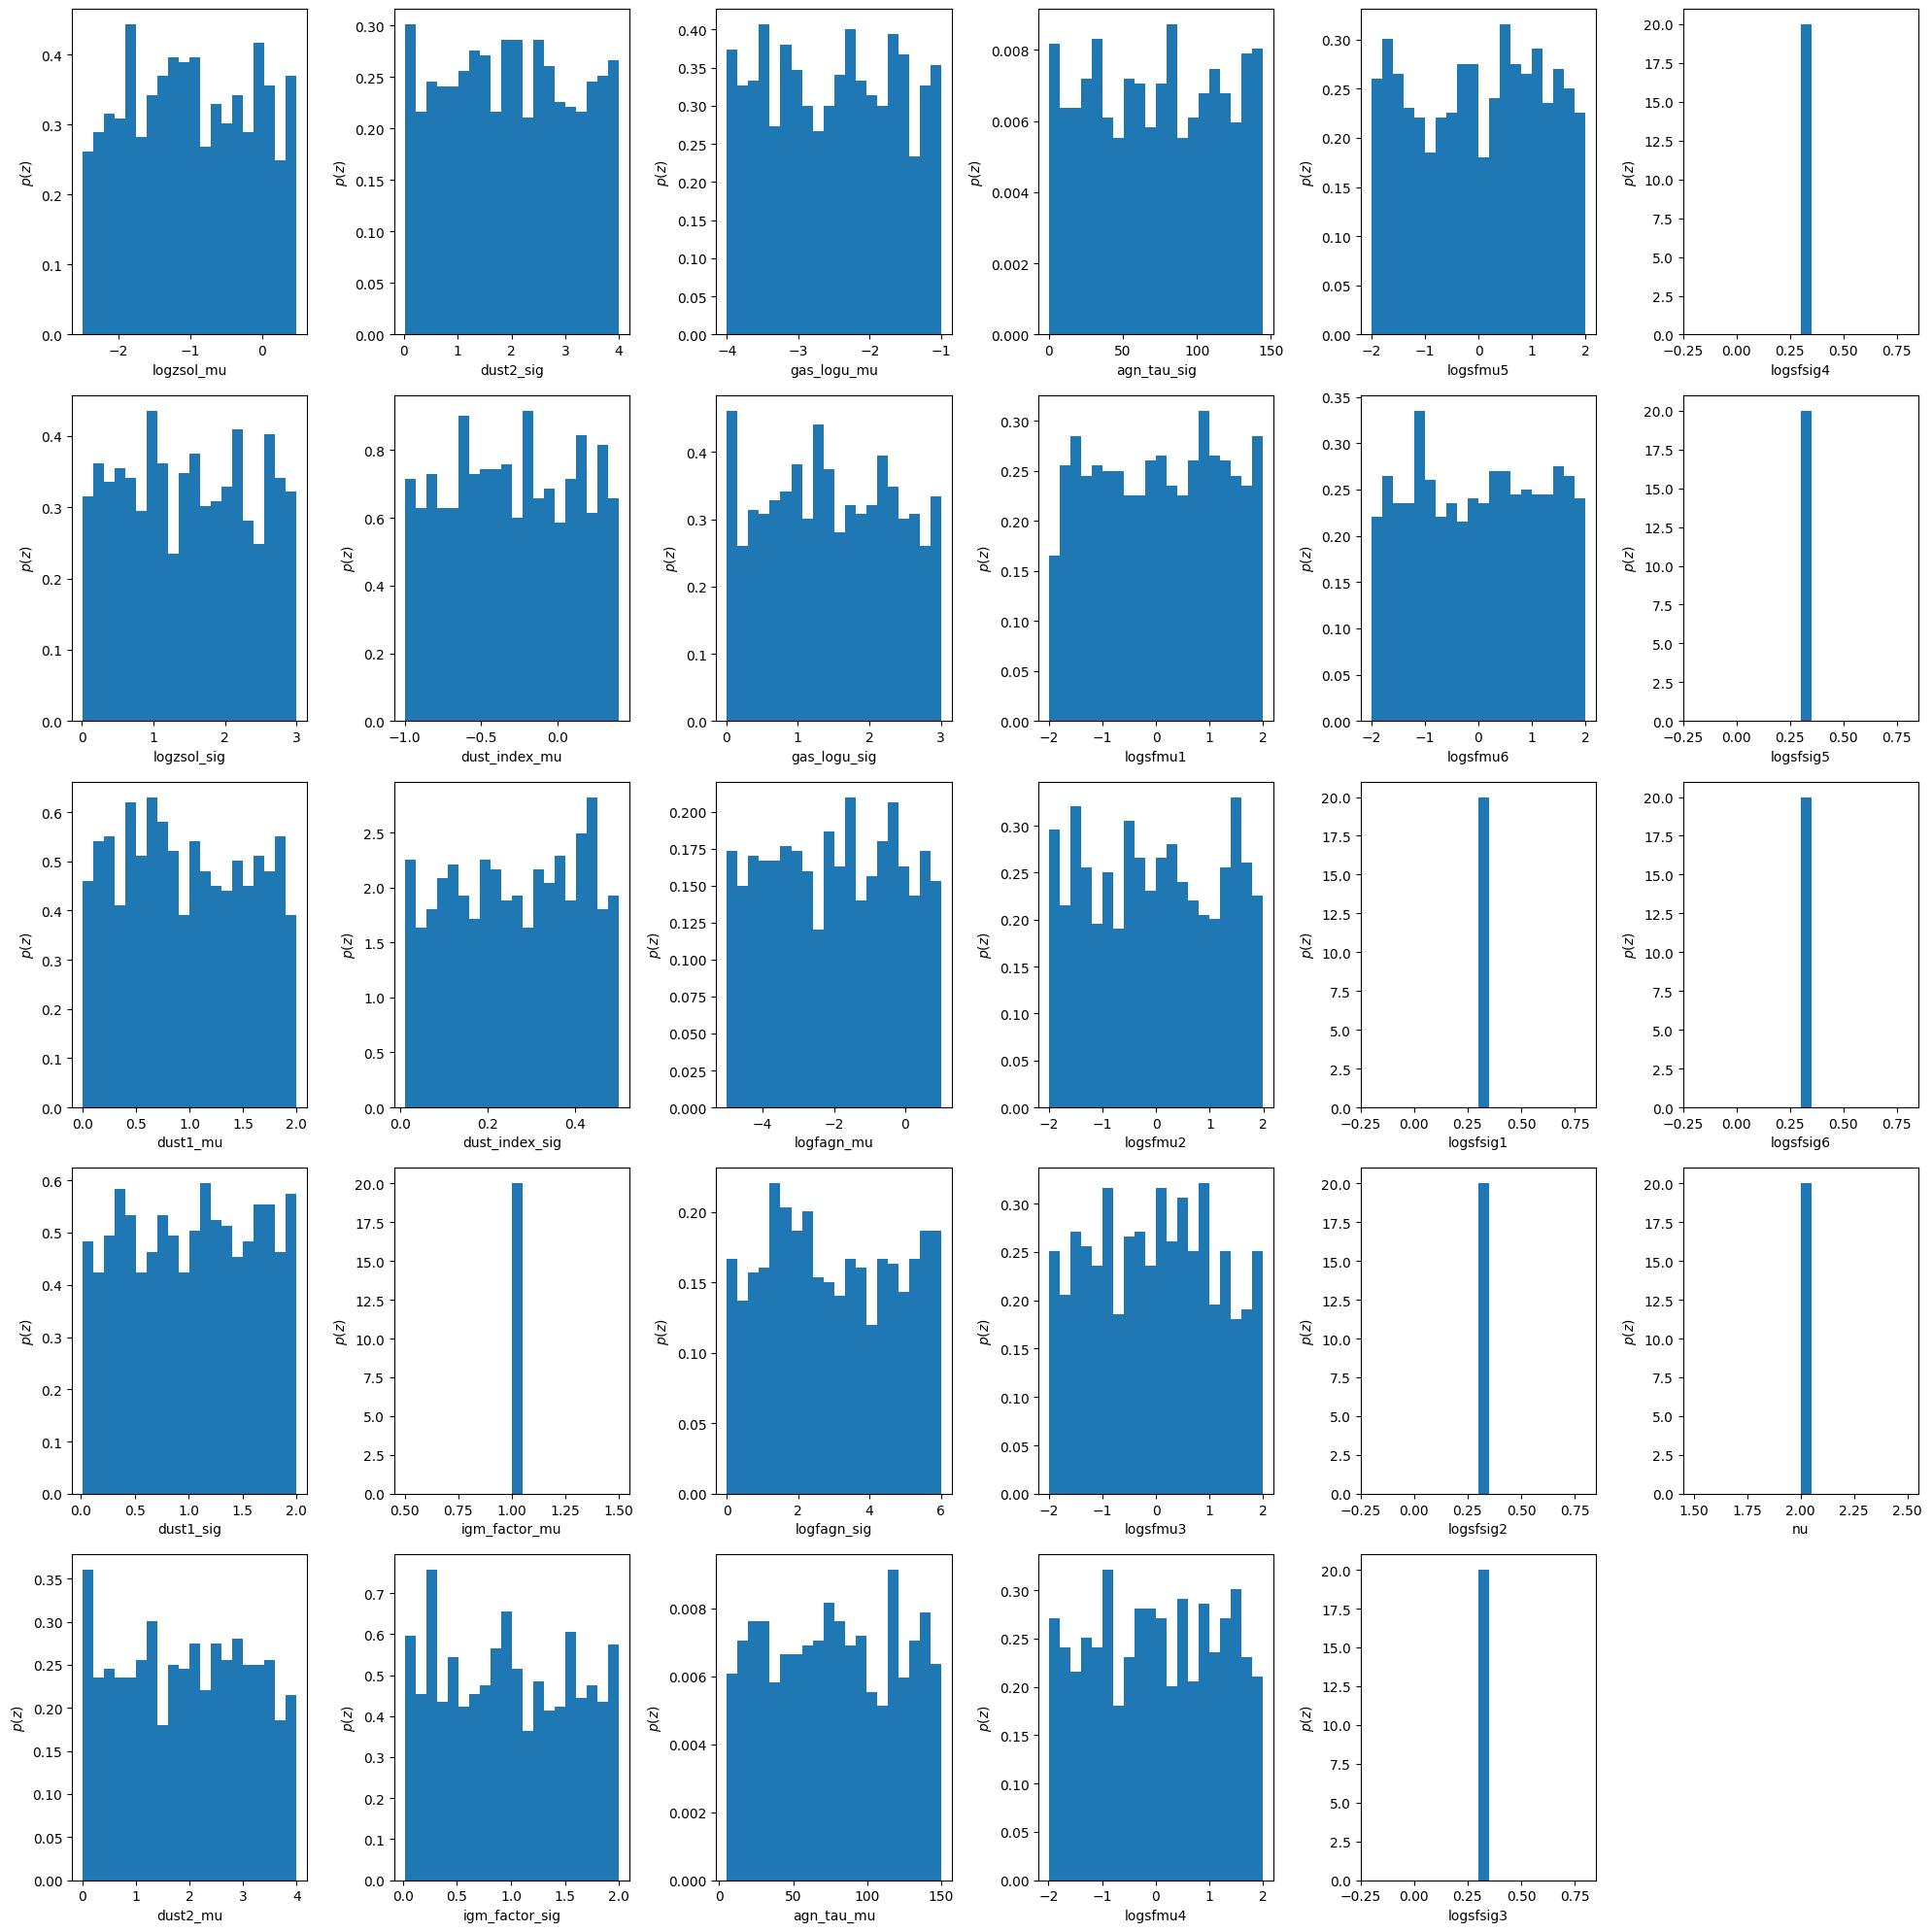

In [5]:
prior_parameters = hyp.sample_prior_parameters(1000, hyperparameter_mu_bounds, hyperparameter_sigma_max)
hyp.plot_hyperparameters(prior_parameters)

In [6]:
redshift_mass_prior_parameters = pr.setup_redshift_and_mass_priors(z_max=12)

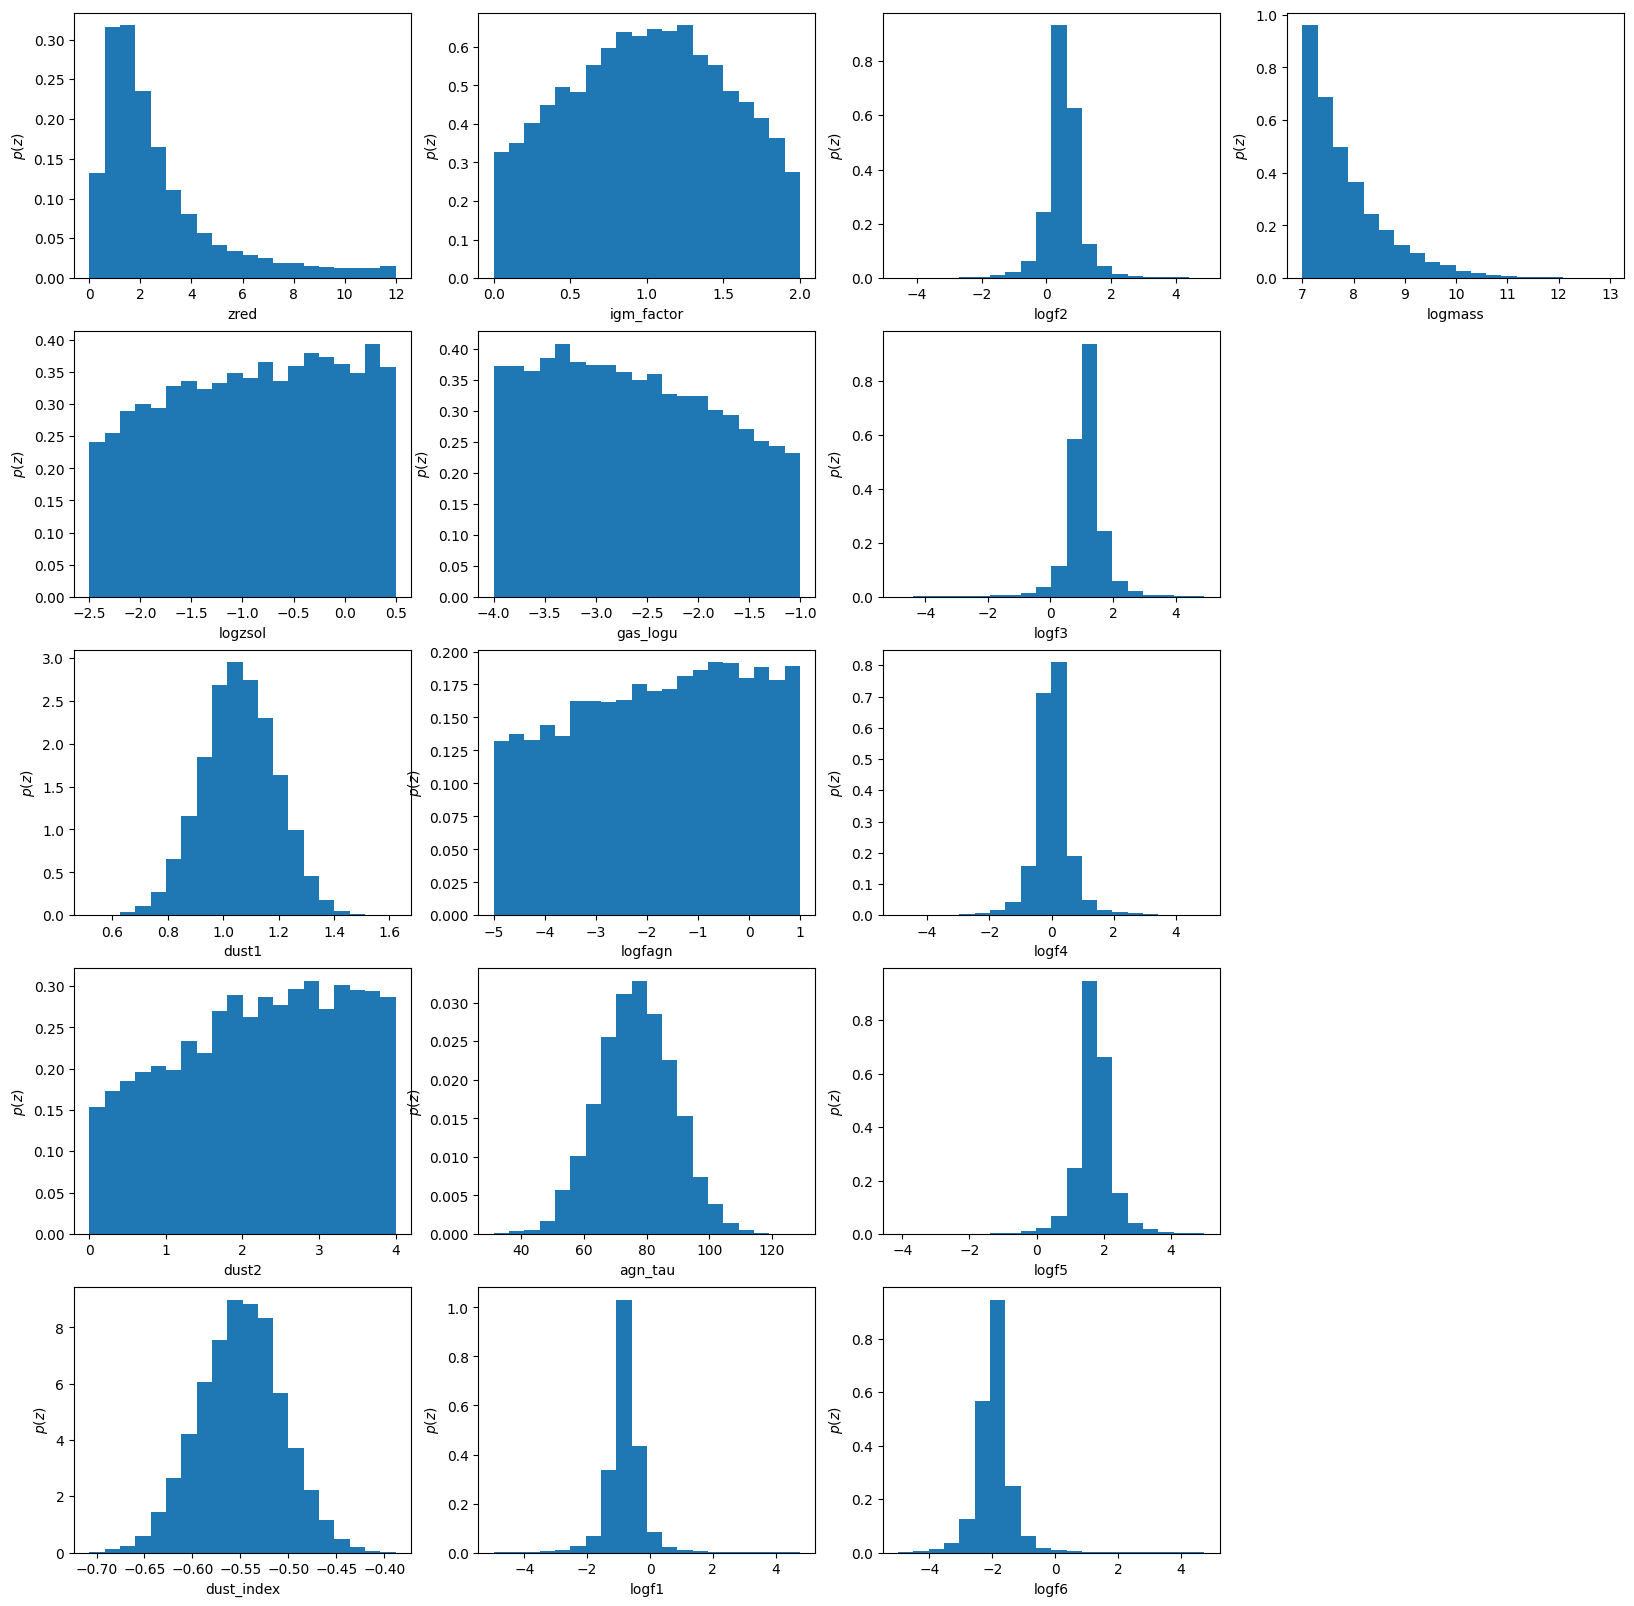

In [11]:
sps_parameters = pop.generate_sps_parameters(10000, prior_parameters[np.random.randint(0, 1000),:], redshift_mass_prior_parameters)
pop.plot_galaxy_population(sps_parameters, rows=5, nbins=20)

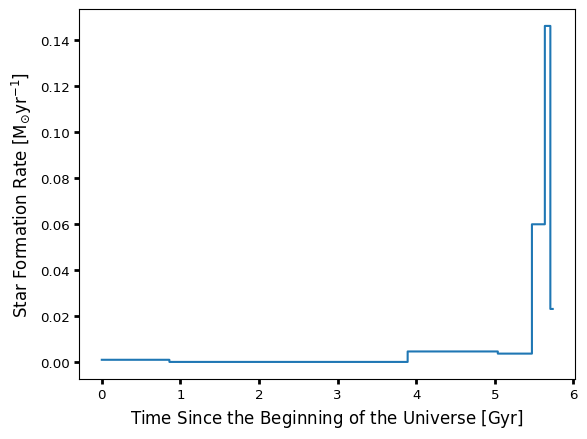

In [12]:
sfh.sps_parameters_to_sfh(sps_parameters[0,:], sfh.default_agebins())

0.001910280970306916 0.001910243525224422 28803790.1245455 28803790.124545496


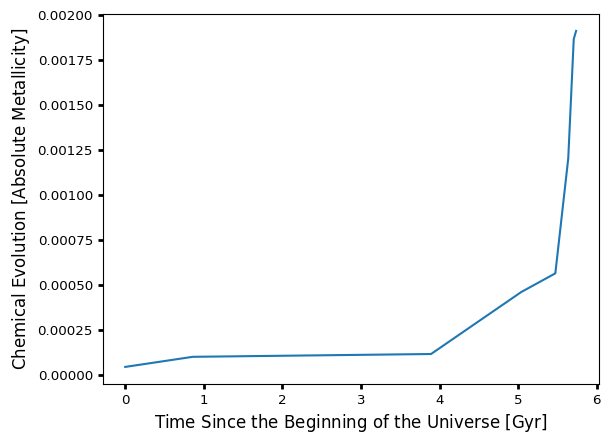

In [13]:
zh.sps_parameters_to_zhistory(sps_parameters[0,:], sfh.default_agebins())